## LangChain Agents

In [1]:
import os
from getpass import getpass

os.environ["DEEPINFRA_API_TOKEN"] = getpass("Digite sua chave da DeepInfra: ")

In [2]:

from langchain_community.chat_models import ChatDeepInfra
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

chat = ChatDeepInfra(model="deepseek-ai/DeepSeek-V3") 


In [3]:
from getpass import getpass

os.environ["TAVILY_API_KEY"] = getpass("Digite sua chave do Travily: ")
#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

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults(max_results=2)
search_results = tavily.invoke("Qual a temperatura na cidade de Belo Horizonte hoje?")
print(search_results)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17828\3558227869.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(max_results=2)


[{'title': 'Belo Horizonte, MG | Previsão do Tempo - G1 - Globo', 'url': 'https://g1.globo.com/previsao-do-tempo/mg/belo-horizonte.ghtml', 'content': 'Período marca início da estação seca na capital, e época em que dia e noite têm mesma duração. Especialistas esperam seca prolongada.\n\nMoradores do DF comemoram chuva na capital; veja imagens\n\nMoradores do DF comemoram chuva na capital; veja imagens\n\nSegundo Inmet, pancadas isoladas acompanhadas de rajadas de vento e trovoadas se repetem ao longo da semana. Calor continua com temperatura chegando a 32°C. [...] Hoje, terça-feira\n\nBelo Horizonte, MG\n\nSol com muitas nuvens durante o dia e períodos de céu nublado. Noite com muitas nuvens.\n\nManhã\n\nTarde\n\nNoite\n\nPróximos dias\n\nPrevisão pelo Brasil\n\nInformações meteorológicas fornecidas pelo CLIMATEMPO e sujeitas a disponibilidade do seu serviço\n\nMaio terá tardes secas e madrugadas mais frias com fim das chuvas no DF\n\nMaio terá tardes secas e madrugadas mais frias com 

In [45]:
# NOVO CONTEÚDO PARA AS CÉLULAS 7 E 8

import pandas as pd
import os
import functools
from langchain.agents import tool
from pydantic.v1 import BaseModel, Field

# --- 1. DEFINIÇÃO DAS FUNÇÕES SIMPLES ---

@tool
def get_column_names(df: pd.DataFrame) -> str:
    """
    Retorna uma lista com todos os nomes das colunas do dataset.
    Útil para saber quais colunas estão disponíveis para análise.
    """
    return str(df.columns.tolist())

@tool
def summary_statistics(df: pd.DataFrame, column_name: str) -> str:
    """
    Calcula estatísticas descritivas para uma coluna numérica específica.
    Retorna média, desvio padrão, mínimo, máximo e os quartis.
    """
    try:
        return df[column_name].describe().to_string()
    except KeyError:
        return f"Erro: A coluna '{column_name}' não existe. Colunas disponíveis: {df.columns.tolist()}"
    except TypeError:
        return f"Erro: A coluna '{column_name}' não parece ser numérica. Tente usar 'value_counts'."

@tool
def value_counts(df: pd.DataFrame, column_name: str) -> str:
    """
    Conta a frequência de cada valor único em uma coluna categórica.
    """
    try:
        return df[column_name].value_counts().to_string()
    except KeyError:
        return f"Erro: A coluna '{column_name}' não existe. Colunas disponíveis: {df.columns.tolist()}"

@tool
def check_missing_values(df: pd.DataFrame, column_name: str) -> str:
    """
    Verifica e conta a quantidade de valores nulos (NaN) em uma coluna específica.
    """
    try:
        missing_count = df[column_name].isnull().sum()
        return f"A coluna '{column_name}' tem {missing_count} valores faltantes."
    except KeyError:
        return f"Erro: A coluna '{column_name}' não existe. Colunas disponíveis: {df.columns.tolist()}"

@tool
def calculate_correlation(df: pd.DataFrame, column_a: str, column_b: str) -> str:
    """
    Calcula a correlação entre duas colunas numéricas. O valor varia de -1 a 1.
    """
    try:
        correlation = df[[column_a, column_b]].corr().iloc[0, 1]
        return f"A correlação entre '{column_a}' e '{column_b}' é: {correlation:.4f}"
    except KeyError as e:
        return f"Erro: Uma das colunas não existe. Coluna não encontrada: {e}. Colunas disponíveis: {df.columns.tolist()}"
    except TypeError:
        return f"Erro: Uma ou ambas as colunas não são numéricas. Não é possível calcular a correlação."

# Adicione esta função junto com as outras ferramentas simples

@tool
def python_repl(df: pd.DataFrame, code: str) -> str:
    """
    Executa um código Python (especificamente pandas) em um DataFrame.
    Use esta ferramenta para análises complexas, filtros, agregações ou qualquer
    operação que não seja coberta pelas outras ferramentas simples.
    O DataFrame está disponível como a variável 'df'.
    O código deve ser uma única expressão que retorna um resultado (ex: df[df['coluna'] > 10]).
    """
    try:
        # Cria um ambiente seguro com acesso ao pandas (pd) e ao dataframe (df)
        local_vars = {"df": df, "pd": pd}
        # Executa o código usando eval, que é mais seguro por só avaliar expressões
        result = eval(code, {"__builtins__": None}, local_vars)
        return f"Execução bem-sucedida. Resultado:\n{str(result)}"
    except Exception as e:
        return f"Erro ao executar o código: {e}. Por favor, corrija o código e tente novamente."


In [ ]:
# MUDAR ESTA CÉLULA (ID: f86c25e1)

import functools
from langchain.tools import Tool
from langchain_community.tools.tavily_search import TavilySearchResults

# Garante que o DataFrame 'df' e as funções-ferramenta (get_column_names, etc.) já foram definidos nas células anteriores.
# Supondo que 'tavily' também já foi definido.

# Criamos a lista final de ferramentas executáveis.
# Usamos functools.partial para "pré-carregar" o DataFrame 'df' em cada função.
tools = [
    tavily,
    Tool(
        name="get_column_names",
        func=functools.partial(get_column_names, df=df),
        description="Retorna uma lista de todos os nomes de colunas do dataset."
    ),
    Tool(
        name="summary_statistics",
        func=functools.partial(summary_statistics, df=df),
        description="Calcula estatísticas descritivas para uma coluna numérica."
    ),
    Tool(
        name="value_counts",
        func=functools.partial(value_counts, df=df),
        description="Conta a frequência de valores em uma coluna categórica."
    ),
    Tool(
        name="check_missing_values",
        func=functools.partial(check_missing_values, df=df),
        description="Verifica valores nulos em uma coluna."
    ),
    Tool(
        name="calculate_correlation",
        func=functools.partial(calculate_correlation, df=df),
        description="Calcula a correlação entre duas colunas."
    ),
    Tool(
        name="python_repl",
        func=functools.partial(python_repl, df=df),
        description="Executa código Python genérico no DataFrame 'df' para análises complexas."
    )
]

# As listas 'executable_tools' e 'tools_for_binding' não são mais necessárias.
# Esta célula agora tem uma única responsabilidade: criar a lista 'tools'.
print(f"Lista de {len(tools)} ferramentas criada com sucesso.")


DataFrame carregado com 26208 linhas e 359 colunas.


In [47]:
chat_with_tools = chat.bind(functions=tools_for_binding)


In [48]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.prompts import HumanMessagePromptTemplate
from langchain.tools.render import render_text_description
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

In [49]:
# ✅ Etapa 1: Definir o Estado do Grafo

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [ ]:
from langgraph.prebuilt import ToolNode

# Esta é a função 'chatbot' corrigida.
def chatbot(state: State):
    """Nó que chama o LLM, garantindo que as instruções do sistema sejam incluídas."""
    print("---EXECUTANDO NÓ CHATBOT (COM INSTRUÇÕES)---")
    
    # Associa as ferramentas ao modelo para esta chamada específica.
    # A linha 'chat_with_tools = chat.bind(functions=tools_for_binding)' da célula 4b6865f8 não é mais necessária.
    chat_with_tools = chat.bind_tools(tools)
    
    # AQUI ESTÁ A MÁGICA: Formata o histórico de mensagens usando seu template de regras.
    prompt = primary_assistant_prompt.format_messages(**state)
    
    # Invoca o modelo com o prompt formatado (regras + conversa).
    response = chat_with_tools.invoke(prompt)
    
    return {"messages": [response]}


# O resto da célula continua como estava, adicionando os nós ao grafo.
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

print("Nós 'chatbot' e 'tools' adicionados ao grafo.")

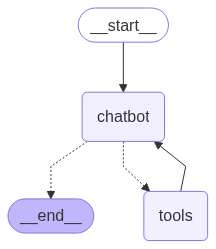

In [51]:
# ✅ Etapa 3: Criar o grafo

graph_builder.add_edge(START, "chatbot")

# chatbot --> tool    é o chatbot quem decide se vai empregar as ferramentas ou não
graph_builder.add_conditional_edges("chatbot", tools_condition)

# tool ---> chatbot   uma vez que a ferramenta foi utilizada ela precisa retornar ao ll,
graph_builder.add_edge("tools", "chatbot")

checkpointer=MemorySaver()
# config = config = {"configurable": {"thread_id": "1"}}  # Uma thread_id para cada conversação

config = {
    "configurable": {
        "api_key": "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",  # key da deepinfra ou 
        "model": "deepseek-ai/DeepSeek-V3",  # Your model
        "thread_id": "1"  # Optional conversation tracking
    }
}

graph = graph_builder.compile(checkpointer=checkpointer)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Tentando usar "Iterative Refinement Prompting" & "Reasoning and Acting"
# Possíveis mudanças: usar mais "Identity Prompting"; aprender "Meta Prompting";  aumentar o "Self-reflection Prompts"; usar LLM para gerar o "Iterative Refinement Prompting"

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Agora que 'tools' existe, podemos usá-la para gerar a descrição.
tools_description = "\n".join([f"- **{tool.name}**: {tool.description}" for tool in tools])

react_template = f"""
Você é um assistente de análise de dados. Você NÃO TEM acesso direto ao conteúdo do dataset. Sua ÚNICA maneira de obter informações sobre os dados é através do uso das ferramentas disponíveis.
O dataset é um dataframe em pandas chamado "df".

Você tem acesso às seguintes ferramentas:
{tools_description}

**NUNCA invente ou presuma nada sobre o dataset (nomes de colunas, valores, etc.). Se você não sabe algo, sua primeira ação DEVE ser usar uma ferramenta para descobrir. Para QUALQUER pergunta sobre o dataset, seu primeiro passo é quase sempre usar a ferramenta `get_column_names` para se orientar.**


### REGRAS DE EXECUÇÃO
1.  **Ciclo de Análise**: Você deve decompor o problema em passos. Para cada passo, você gerará um **Pensamento** e uma **Ação**. Sua resposta DEVE parar após o JSON da Ação.
2.  **Análise da Observação**: Após sua ação, o sistema fornecerá uma **Observação**. Você DEVE analisar esta observação (seja um resultado ou um erro) para formular seu próximo Pensamento e Ação.
3.  **Simplicidade das Ferramentas**: As ferramentas são simples. Elas NÃO aceitam filtros ou lógicas complexas no `action_input`. Se uma tarefa requer múltiplos passos (como filtrar por data e depois contar), você DEVE usar ferramentas em passos separados.
4.  **Formato do Input**: O formato de `action_input` é CRÍTICO. Para ferramentas que pedem um nome de coluna (como `value_counts`), o input deve ser uma STRING SIMPLES (ex: `"Minha_Coluna"`), não um objeto JSON.

### EXEMPLO DE CICLO DE CORREÇÃO (Seu Guia)

Veja um exemplo de como reagir a um erro:

Pergunta: Qual a distribuição da coluna 'Vendas'?
Pensamento: A pergunta é sobre a coluna 'Vendas'. Vou usar a ferramenta `value_counts` para ver a distribuição dos valores.
Ação:
```json
{{
"action": "value_counts",
"action_input": {{
"column_name": "Vendas"
}}
}}
```
Observação: Erro: O input para 'value_counts' deve ser uma string, não um objeto.
Pensamento: Ocorreu um erro. A observação diz que o action_input para value_counts deve ser uma string simples, mas eu enviei um objeto JSON. Além disso, não tenho certeza se 'Vendas' é o nome exato da coluna. Vou primeiro verificar todos os nomes de colunas disponíveis para ter certeza e depois tentarei chamar value_counts com o formato correto.
Ação:
```json
{{
"action": "get_column_names",
"action_input": {{}}
}}
```
Observação: ['Timestamp', 'Vendas_Totais', 'Regiao', 'ID_Produto']
Pensamento: Agora vejo o nome correto da coluna é 'Vendas_Totais'. Vou chamar value_counts novamente, desta vez com o nome correto e no formato de string simples, como a primeira mensagem de erro instruiu.
Ação:
```json
{{
"action": "value_counts",
"action_input": "Vendas_Totais"
}}
```
Observação: [Resultado da ferramenta value_counts]
Pensamento: Agora tenho a informação que preciso para responder.
Resposta Final: A distribuição da coluna 'Vendas_Totais' é a seguinte...


SEU TURNO
Agora, siga o mesmo processo. Use o formato abaixo, parando sempre após a Ação.

Formato:
Pergunta: a pergunta de entrada que você deve responder
Pensamento: ...
Ação:
```json
{{
"action": "nome da ferramenta",
"action_input": "entrada da ferramenta"
}}
```

"""
primary_assistant_prompt = ChatPromptTemplate.from_messages(
[
("system", react_template),
MessagesPlaceholder(variable_name="messages"),
]
)

print("Prompt do assistente criado com sucesso.")


SyntaxError: f-string: empty expression not allowed (29923883.py, line 77)

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage

# Usar um novo thread_id para garantir que a conversa comece do zero com a nova lógica.
config = {"configurable": {"thread_id": "conversa_final_corrigida"}} 

while True:
    try:
        user_input = input("Você: ")
        if user_input.lower() in ["quit", "exit", "sair"]:
            print("Encerrando a conversa.")
            break

        inputs = {"messages": [HumanMessage(content=user_input)]}

        print("\nAssistente:")
        for output in graph.stream(inputs, config=config, stream_mode="values"):
            last_message: BaseMessage = output["messages"][-1]
            
            if isinstance(last_message, AIMessage) and last_message.tool_calls:
                tool_call = last_message.tool_calls[0]
                print(f"⚙️  Pensando... Vou usar a ferramenta `{tool_call['name']}` com os argumentos: {tool_call['args']}")

            elif isinstance(last_message, AIMessage) and last_message.content:
                print(f"🤖  {last_message.content}")

        print("\n" + "="*50 + "\n")
    except KeyboardInterrupt:
        print("\nConversa interrompida.")
        break


Assistente:
================================ Human Message =================================

descreva meu dataset
---DEBUG: Última mensagem: None---

Para descrever seu dataset com precisão, preciso de algumas informações básicas sobre ele. Aqui estão os aspectos principais que ajudariam a entender e descrever melhor seus dados:

### 1. **Estrutura do Dataset**
   - Quantas **linhas** (observações) e **colunas** (variáveis/atributos) o dataset possui?
   - Qual o **tipo de dados** em cada coluna (numérico, categórico, texto, data, etc.)?

### 2. **Contexto e Finalidade**
   - Qual é o **contexto** dos dados? Por exemplo, são dados financeiros, de saúde, de vendas, de sensores, etc.?
   - Qual é o **objetivo** ou uso do dataset (análise exploratória, modelagem preditiva, etc.)?

### 3. **Origem dos Dados**
   - De onde os dados foram coletados? Por exemplo, de uma pesquisa, API, banco de dados, web scraping, etc.
   - Os dados são **públicos** ou **privados**?

### 4. **Variáveis (Col

KeyboardInterrupt: Interrupted by user

In [95]:
# ✅ Etapa 5: Conversar com o agente
estado = graph.invoke({"messages": prompt.format_messages(question = "Oi, como é nosso dataset?")}, config) # Teste com uma pergunta onde o agente precisa usar apenas 1 tool.

In [98]:
estado["messages"][-1].content

'Pensamento: Para entender melhor o dataset, primeiro preciso saber quais colunas estão disponíveis. Vou usar a ferramenta `get_column_names` para obter a lista de colunas.\n\nAção:\n```json\n{\n"action": "get_column_names",\n"action_input": {}\n}\n```'

In [24]:
estado = graph.invoke({"messages": prompt.format_messages(question = "Qual a temperatura de São Paulo hoje e escreva a resposta em maiúsculo")}, config) # Teste com uma pergunta onde o agente precisa usar 2 tools.

In [25]:
estado["messages"][-1].content

'Pergunta: Qual a temperatura de São Paulo hoje e escreva a resposta em maiúsculo?\n\nPensamento: Tentei responder frequentemente, mas a busca anterior não retornou resultados relevantes. Vou tentar novamente.\n\nAção:\n<function=tavily_search_results_json>{"query": "temperatura em São Paulo atuais"}'

In [26]:
estado = graph.invoke({"messages": prompt.format_messages(question = "Quanto é 5+5")}, config) # Teste com uma pergunta onde o agente não precisa usar nenhuma tool.

In [27]:
estado["messages"][-1].content

'Pergunta: Quanto é 5+5\n\nPensamento: Eu sei essa resposta pela cabeça!\n\nResposta Final: 10'